In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [91]:
base_treino = pd.read_csv(r"D:\pipeline_dados\base_orcamentos_treino.csv")

In [92]:
base_avaliacao = pd.read_csv(r"D:\pipeline_dados\base_orcamentos_nov.csv")

In [93]:
categoricos = ['id_quote',
 'dt_criacao',
 'ds_tipo_obra',
 'nm_prop_oportunidade',
 'proprietario',
 'promocional',
 'tipo_loja',
 'banheiro',
 'toda_casa',
 'cozinha',
 'area_externa',
 'itens_assentamento',
 'sala',
 'piscina',
 'area_servico',
 'garagem',
 'dormitorio',
 'varanda',
 'escada',
 'amb_outros']

In [94]:
categoricos

['id_quote',
 'dt_criacao',
 'ds_tipo_obra',
 'nm_prop_oportunidade',
 'proprietario',
 'promocional',
 'tipo_loja',
 'banheiro',
 'toda_casa',
 'cozinha',
 'area_externa',
 'itens_assentamento',
 'sala',
 'piscina',
 'area_servico',
 'garagem',
 'dormitorio',
 'varanda',
 'escada',
 'amb_outros']

In [95]:
encoder = OneHotEncoder(drop='if_binary')
df_encoded = pd.DataFrame(encoder.fit_transform(base_treino[categoricos]).toarray(), columns=encoder.get_feature_names_out(categoricos))
df_final = pd.concat([base_treino.drop(categoricos, axis=1), df_encoded], axis=1)

In [96]:
X = df_final.drop('convertido', axis=1)
y = df_final['convertido']

In [97]:
from sklearn.feature_selection import VarianceThreshold


In [98]:
var_threshold = 0.40
selector = VarianceThreshold(threshold=(var_threshold * (1 - var_threshold)))
X_high_variance = selector.fit_transform(X)

In [99]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [100]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X_high_variance, y, test_size=0.2, random_state=42,stratify=y)

In [101]:
scaler = StandardScaler()
x_treino = scaler.fit_transform(x_treino)
x_teste = scaler.transform(x_teste)

In [102]:
smote = SMOTE(random_state=42)
x_treino_resampled, y_treino_resampled = smote.fit_resample(x_treino, y_treino)

In [103]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [104]:

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=0.001,
    reg_lambda=0.001
)

In [105]:
grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(x_treino_resampled, y_treino_resampled)

best_params = grid_search.best_params_

In [106]:

modelo_xgboost = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=0.001,
    reg_lambda=0.001,
    **best_params
)
modelo_xgboost.fit(x_treino_resampled, y_treino_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [107]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [108]:

y_pred = modelo_xgboost.predict(x_teste)
matriz_confusao = confusion_matrix(y_teste, y_pred)

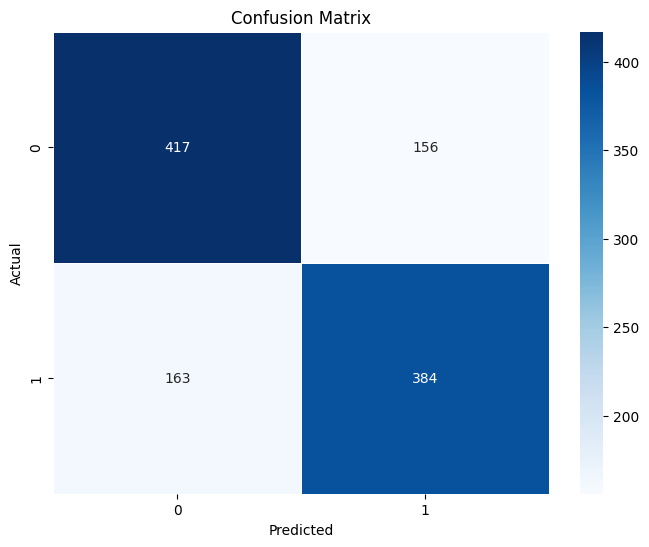

In [109]:

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [110]:

importances = modelo_xgboost.feature_importances_
variable_names = df_final.drop(['convertido'], axis=1).columns[selector.get_support()]


df_importances = pd.DataFrame({'Variable': variable_names, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

In [111]:
print("Importancia das variaveis:")
print(df_importances)

Importancia das variaveis:
                  Variable  Importance
7            vlr_orcamento    0.193093
9          nao_convertidos    0.150805
0              dias_desejo    0.131166
8              convertidos    0.084753
6                 vl_frete    0.074610
12            amb_outros_S    0.064076
2             revestimento    0.062862
5              arg_rejunte    0.049637
1             dias_em_casa    0.047517
10  ds_tipo_obra_Nova Obra    0.044229
4            loucas_metais    0.037724
3                 officina    0.031905
11    ds_tipo_obra_Reforma    0.027624


C:\Users\Guilherme\AppData\Local\Temp\ipykernel_28028\1737072124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable', data=df_importances, palette='viridis')


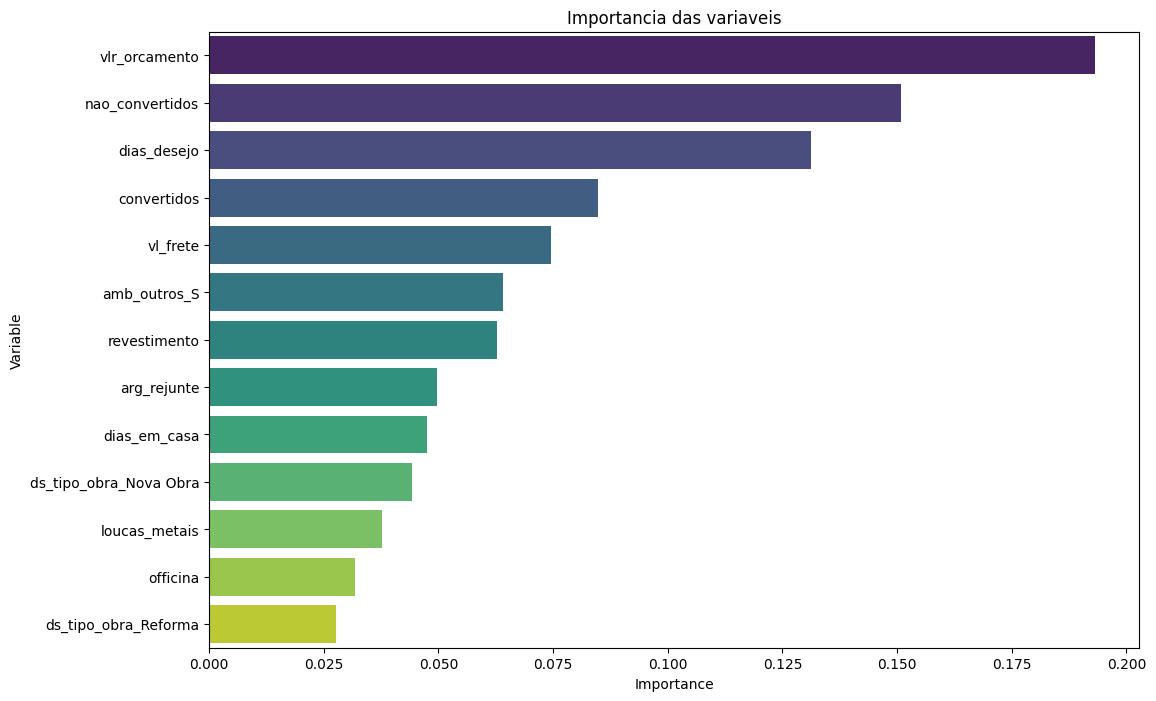

In [112]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Variable', data=df_importances, palette='viridis')
plt.title('Importancia das variaveis')
plt.show()

In [113]:

print("\nClassification Report:")
print(classification_report(y_teste, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       573
           1       0.71      0.70      0.71       547

    accuracy                           0.72      1120
   macro avg       0.72      0.71      0.71      1120
weighted avg       0.72      0.72      0.72      1120



In [114]:

acuracia = accuracy_score(y_teste, y_pred)
print(f'Acurácia no conjunto de teste: {acuracia * 100:.2f}%')

Acurácia no conjunto de teste: 71.52%


In [115]:
probabilidades_teste = modelo_xgboost.predict_proba(x_teste)[:, 1]


x_teste_df = pd.DataFrame(x_teste, columns=variable_names)
df_temporario_teste = pd.DataFrame({
    'nm_prop_oportunidade': base_treino.loc[x_teste_df.index, 'nm_prop_oportunidade'],
    'convertido': y_teste,
    'id_quote': base_treino.loc[x_teste_df.index, 'id_quote'],
    'probabilidade_conversao': probabilidades_teste
})

df_temporario_teste = df_temporario_teste.drop_duplicates(subset=['nm_prop_oportunidade', 'convertido', 'id_quote'])

df_resultados_teste = df_temporario_teste.groupby('nm_prop_oportunidade', as_index=False).agg({
    'convertido': 'first',
    'probabilidade_conversao': 'mean',
    'id_quote': 'first' 
})

with pd.option_context('display.max_rows', None):
    display(df_resultados_teste[['nm_prop_oportunidade', 'convertido', 'probabilidade_conversao', 'id_quote']])

,nm_prop_oportunidade,convertido,probabilidade_conversao,id_quote
0,adryson pinto freitas,0,0.505347,0Q03s000000SgjJCAS
1,ana paula goncalves lemos,0,0.470724,0Q03s000000GbRDCA0
2,bruno schmelzer de souza,0,0.516673,0Q03s000000GSpmCAG
3,claudia marina silva,1,0.515558,0Q03s000000GUhUCAW
4,dara jenifer de jesus,1,0.236873,0Q03s000000SYHxCAO
5,ediane rosa,0,0.668896,0Q03s000000SgIICA0
6,fabiano martins werutsky,0,0.483850,0Q03s000000GRwXCAW
7,juliana westphalen gonçalves,0,0.539846,0Q03s000000GS97CAG
8,leticia silva de arruda,0,0.497925,0Q03s000000GRoxCAG
9,luis roberto da silva ferreira junior,1,0.505093,0Q03s000000GSIiCAO


In [117]:
df_resultados_teste.to_csv("orcamentos_xgboost_classifier.csv")